# Bayesian Optimization

Following notebook will help to understand what bayesian optimization is and when to use bayesian optimization. Continuing to this we will also optimize the hyperparameters for one of the algorithms and try to estimate its performance on the test set as compared to normal random or grid search.

Bayesian optimization belongs to class of sequential based models where the objective is to optimize the loss function by seaching the best optimal hyperparameters.
Bayesian optimization surpasses the challenge of time consuming from manual grid search where the algorithm has to iterate over eery combination to find the optimal. This class of function is used when there are 2 problems:
* if there are lot of hyperparams to search 
* if out of sample data takes time to evaluate

The below equation illustrates on how bayesian optimization words:
Objective is to optimize some performance metric f: where f : f(Model)(theta|Data),
* f: performance metric function to optimize
* Model : type of model that uses optimized hyperparams
* theta : set of hyperparams
* Data : input data

Bayesian optimization uses some prior distribution like gaussian process or probability distribution of the historical learned data point. Using this prior/probability distribution over the points , the acquition function/ EI(expected improvement) formalizes what constitutes the best guess for next point to iterate.


## Hyperopt

There are many open source libraries to build the optimization f. One of them is Hyperopt.
hese libraries differ in the algorithm used to both construct the surrogate (probability model) of the objective function and choose the next hyperparameters to evaluate in the objective function. Hyperopt uses the Tree Parzen Estimator (TPE). Other Python libraries include Spearmint, which uses a Gaussian process for the surrogate, and SMAC, which uses a random forest regression.

Hyperopt has a simple syntax for structuring an optimization problem which extends beyond hyperparameter tuning to any problem that involves minimizing a function. Moreover, the structure of a Bayesian Optimization problem is similar across the libraries

In [38]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

MAX_EVALS = 500
N_FOLDS = 10

from sklearn.metrics import roc_auc_score

## Dataset

The objective is to determine whether or not a potential customer will buy an insurance policy by training a model on past data. This is a straightforward supervised machine learning classification task: given past data, we want to train a model to predict a binary outcome on testing data.

In [6]:
import os
os.chdir('/Users/ankitpatel/Downloads/Bayesianoptimization/')

In [7]:
# Read in data and separate into training and testing sets
data = pd.read_csv('caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


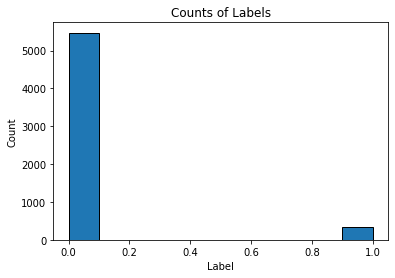

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels, edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

The above distribution is a typical example of imbalanced data having majority of '0' and minority of '1'.

## Constructing a default gradient boosting model

In [15]:
# Model with default hyperparameters
model = lgb.LGBMClassifier(random_state=123)
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7092.
The baseline training time is 0.1797 seconds


## Random Search 

Each iteration, we choose a random set of model hyperparameters from a search space. Empirically, random search is very effective, returning nearly as good results as grid search with a significant reduction in time spent searching. However, it is still an uninformed method in the sense that it does not use past evaluations of the objective function to inform the choices it makes for the next evaluation.

Random search can be implemented in the Scikit-Learn library using RandomizedSearchCV, however, because we are using Early Stopping (to determine the optimal number of estimators), we will have to implement the method ourselves.This is pretty straightforward, and many of the ideas in random search will transfer over to Bayesian hyperparameter optimization.

In [17]:
import random
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Boosting type=goss does not choose row sampling so instean subsample we will use subsample_dist for goss only

In [18]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

## Sampling from hyperparams

Sample a set of hyperparameters from our grid using a dictionary comprehension.

In [19]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'class_weight': 'balanced',
 'boosting_type': 'dart',
 'num_leaves': 53,
 'learning_rate': 0.013956885011186672,
 'subsample_for_bin': 240000,
 'min_child_samples': 325,
 'reg_alpha': 0.4693877551020408,
 'reg_lambda': 0.9591836734693877,
 'colsample_bytree': 0.8222222222222222}

To add a subsample ratio if the boosting_type is not goss, we can use an if statement.

In [24]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'class_weight': 'balanced',
 'boosting_type': 'dart',
 'num_leaves': 53,
 'learning_rate': 0.013956885011186672,
 'subsample_for_bin': 240000,
 'min_child_samples': 325,
 'reg_alpha': 0.4693877551020408,
 'reg_lambda': 0.9591836734693877,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 0.7575757575757576}

We set the subsample to 1.0 if boosting type is goss which is the same as not using any subsampling. (Subsampling is when we train on a subset of the rows (observations) rather than all of them. This technique is also referred to as bagging for "bootstrap aggregating").

## Performing CV with 10 folds with early stop rounds 

Create a data set compactible with lightgbm library and creating a base trained model as a benchmark

In [31]:
train_set = lgb.Dataset(features, label = labels)

In [26]:
# Perform cross validation with 10 folds
r = lgb.cv(params, train_set, num_boost_round = 10000, nfold = 10, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 50)

# Highest score
r_best = np.max(r['auc-mean'])

# Standard deviation of best score
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.75998 with std of 0.03962.
The ideal number of iterations was 486.


Store the results will be done via a dataframe where each row will hold one evaluation of the objective function

## result dataframe

In [27]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

## Building the objective function

Here objective function takes the set of hyperprams and evaluate the model by giving the optimal value of the function.We will be using Kfold cross validation with 10 folds to generalize the model on test set. Validation will be a subset of the train set each being fitted 10 times in order to evaluate the performance on the whole 10 distinct validation sets.

Random search works on choosing random set of hyperparams by performing the evaluation on the old set and every time searching the best set in next iteration.

In [29]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

From the above function we are trying to fetch loss value , params set, iteration no, n_estimators and runtime

Running a loop to iterate through the max_vals ,each time taking a unique set of hyperparams

## Random Search

In [ ]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

## Get the output of the Random search

In [31]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params,iteration,estimators,time
0,0.233603,"{'class_weight': 'balanced', 'boosting_type': ...",343,1395,1369.95
1,0.233853,"{'class_weight': None, 'boosting_type': 'gbdt'...",146,438,12.0091
2,0.234248,"{'class_weight': None, 'boosting_type': 'gbdt'...",369,293,7.58439
3,0.235039,"{'class_weight': None, 'boosting_type': 'dart'...",58,152,1036.88
4,0.23528,"{'class_weight': 'balanced', 'boosting_type': ...",260,214,1101.04


In [33]:
random_results.shape

(500, 5)

## Random search performance comparison 

As a reminder, the baseline gradient boosting model achieved a score of 0.71 on the training set. We can use the best parameters from random search and evaluate them on the testing set.

What were the hyperparameters that returned the highest score on the objective function?

In [34]:
random_results.ix[0,'params']

{'class_weight': 'balanced',
 'boosting_type': 'dart',
 'num_leaves': 93,
 'learning_rate': 0.005838803744176648,
 'subsample_for_bin': 280000,
 'min_child_samples': 260,
 'reg_alpha': 0.26530612244897955,
 'reg_lambda': 0.5714285714285714,
 'colsample_bytree': 0.6,
 'subsample': 0.9595959595959596}

## Fit the model with the best params and make prediction on test set 

In [35]:
# Find the best parameters and number of estimators
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.loc[0, 'iteration']))

The best model from random search scores 0.7246 on the test data.
This was achieved using 343 search iterations.


As compared to baseline model prediction on test data the improvement is 0.7246 which is higher.

## Bayesian Optimization using Hyperopt

For Bayesian optimization, we need the following four parts:

* Objective function
* Domain space
* Hyperparameter optimization algorithm
* History of results

### Objective Function

The most important part of this function is that now we need to return a value to minimize and not the raw ROC AUC. We are trying to find the best value of the objective function, and even though a higher ROC AUC is better, Hyperopt works to minimize a function. Therefore, a simple solution is to return 1 - ROC (we did this for random search as well for practice)

If we want to keep track of the number of iterations, we can declare a global variables called ITERATION that is incremented every time the function is called

In [14]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import hyperopt
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

### Domain Space

Specifying the domain (called the space in Hyperopt) is a little trickier than in grid search. In Hyperopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. 

In [15]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

### Example to showcase the prob. distribution of the hyperparams

In [16]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

### Visualizing 10000 samples from the list 

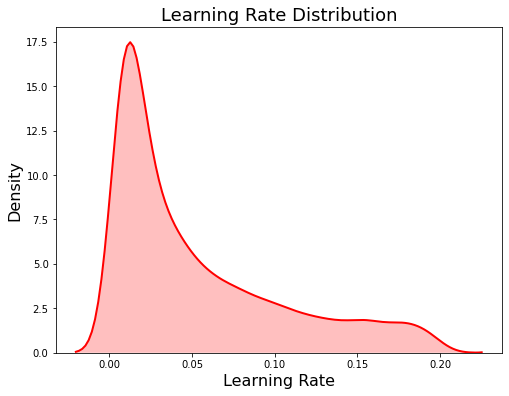

In [17]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

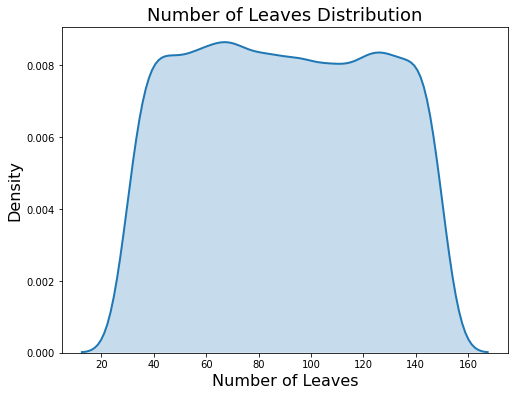

In [42]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

### Conditional Domain

Boosting_type ='goss' cannot take subsample as a fraction so keeping the default value of 1.0 for it.

In [18]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.86109233121088}}

We need to set both the boosting_type and subsample as top-level keys in the parameter dictionary. We can use the Python dict.get method with a default value of 1.0. This means that if the key is not present in the dictionary, the value returned will be the default (1.0).

In [19]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

{'boosting_type': 'dart', 'subsample': 0.86109233121088}

### Bayesian Domain 

In [20]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

### Example for sampling from the domain space 

In [21]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.7423074158335524,
 'learning_rate': 0.19656451300854053,
 'min_child_samples': 280.0,
 'num_leaves': 97.0,
 'reg_alpha': 0.6763019076463495,
 'reg_lambda': 0.8148060411928202,
 'subsample_for_bin': 200000.0,
 'subsample': 0.9749083674776164}

In [22]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 0.7741577432153315,
 'learning_rate': 0.12916463348148494,
 'min_child_samples': 435.0,
 'num_leaves': 35.0,
 'reg_alpha': 0.9736795734237494,
 'reg_lambda': 0.7951830533259983,
 'subsample_for_bin': 40000.0,
 'subsample': 0.5381968524641272}

In [23]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 0.6907104972692333,
 'learning_rate': 0.06639446479857158,
 'min_child_samples': 470.0,
 'num_leaves': 53.0,
 'reg_alpha': 0.9613297591247968,
 'reg_lambda': 0.8484936417423898,
 'subsample_for_bin': 220000.0,
 'subsample': 1.0}

### Implementing TPE of hyperopt

We will use Tree Parzen Estimator to build the surrogate function to chosse the next hyperparameter to evaluate.

In [24]:
from hyperopt import tpe
# optimization algorithm
tpe_algorithm = tpe.suggest

### Storing Results 

* Will use Trails to store the result returned from objective function
* Will use csv file to store the results of each iteration.

Note : use tail results/gbm_trials.csv to check the reults from csv file when the code is executing

In [25]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

The Trials object will hold everything returned from the objective function in the .results attribute. 

In [ ]:
os.mkdir('/Users/ankitpatel/Downloads/BayesianOptimization/results')

In [27]:
os.listdir()

['.DS_Store',
 'caravan-insurance-challenge.csv',
 'results',
 'Bayesian Optimization.ipynb',
 '.ipynb_checkpoints']

In [28]:
# File to save first results
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

Each iteration results are entered into the csv file unders results directory.

### Initialize the Bayesian optimization

In [29]:
## define fmin to pass in everything to the optimizatio algorith
from hyperopt import fmin

In [32]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

Using the .results attribute of the bayes_trials we can obtain the results with min loss 

In [33]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 0.23086088085536471,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.6495509996529543,
   'learning_rate': 0.01389416614407982,
   'min_child_samples': 265,
   'num_leaves': 119,
   'reg_alpha': 0.5541630322600664,
   'reg_lambda': 0.6235648000939851,
   'subsample_for_bin': 220000,
   'subsample': 0.7667005016242243},
  'iteration': 259,
  'estimators': 217,
  'train_time': 5.0003726159993676,
  'status': 'ok'},
 {'loss': 0.23114839004631338,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.6678517942764439,
   'learning_rate': 0.016230048143157004,
   'min_child_samples': 265,
   'num_leaves': 134,
   'reg_alpha': 0.5690669125196127,
   'reg_lambda': 0.5648755175810203,
   'subsample_for_bin': 240000,
   'subsample': 0.6956056666074841},
  'iteration': 262,
  'estimators': 174,
  'train_time': 3.9492016740041436,
  'status': 'ok'}]

### Storing the iteration results

In [34]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.230861,"{'boosting_type': 'gbdt', 'class_weight': None...",259,217,5.000373
1,0.231148,"{'boosting_type': 'gbdt', 'class_weight': None...",262,174,3.949202
2,0.231256,"{'boosting_type': 'gbdt', 'class_weight': None...",258,201,4.218539
3,0.231429,"{'boosting_type': 'gbdt', 'class_weight': None...",386,173,4.084511
4,0.231449,"{'boosting_type': 'gbdt', 'class_weight': None...",207,157,4.570153


In [35]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6495509996529543,
 'learning_rate': 0.01389416614407982,
 'min_child_samples': 265,
 'num_leaves': 119,
 'reg_alpha': 0.5541630322600664,
 'reg_lambda': 0.6235648000939851,
 'subsample_for_bin': 220000,
 'subsample': 0.7667005016242243}

## Evaluate Best Results

For this problem with a relatively small dataset, the benefits of hyperparameter optimization compared to random search are probably minor (if there are any). Random search might turn up a better result in fewer iterations simply becuase of randomness!

In [36]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.6495509996529543, importance_type='split',
               learning_rate=0.01389416614407982, max_depth=-1,
               min_child_samples=265, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=217, n_jobs=-1, num_leaves=119,
               objective='binary', random_state=50,
               reg_alpha=0.5541630322600664, reg_lambda=0.6235648000939851,
               silent=True, subsample=0.7667005016242243,
               subsample_for_bin=220000, subsample_freq=0)

In [39]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.72792 AUC ROC on the test set.
This was achieved after 259 search iterations


The bayesian optimation results to 0.7279 auc value as compared to random search 0.7246 which is slightely more but that much improvement.
We might wan to explore more on the domain space under bayesian optimization as there are chances that the algorithm might shift from exploring(the new value) to exploiting (previously searched best value).his is generally what we want unless the model gets stuck in a local minimum at which point we would want to restart the search in a different region of the hyperparameter space. Bayesian Optimization of hyperparameters is still prone to overfitting, even when using cross-validation because it can get settle into a local minimum of the objective function. It is very difficult to tell when this occurs for a high-dimensional problem!

## End Note 

Bayesian model-based optimization can be more efficient than random search, finding a better set of model hyperparameters in fewer search iterations (although not in every case). However, just because the model hyperparameters are better on the validation set does not mean they are better for the testing set! For this training run, Bayesian Optimization found a better set of hyperparamters according to the validation and the test data although the testing score was much lower than the validation ROC AUC.

Bayesian optimization is a powerful technique that we can use to tune any machine learning model, so long as we can define an objective function that returns a value to minimize and a domain space over which to search. This can extend to any function that we want to minimize (not just hyperparameter tuning). Bayesian optimization can be a significant upgrade over uninformed methods such as random search and because of the ease of use in Python are now a good option to use for hyperparameter tuning.

## Appendix 

* Bayesian Optimization : https://en.wikipedia.org/wiki/Bayesian_optimization
* Hyperopt : https://hyperopt.github.io/hyperopt/
* Tree Parzen Estimator : https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf